In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from stock import *
from sklearn.metrics import mean_absolute_error, mean_squared_error

import mplfinance as mpf

In [2]:
train_loader, test_loader = stock_data_loader("AAPL")

In [6]:
class StockModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=1, output_size=4):
        super(StockModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model = StockModel()

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
n_epochs = 10

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"EPOCH {epoch+1}/{n_epochs}: Loss - {epoch_loss/ len(train_loader):.10f}")

EPOCH 1/10: Loss - 0.0010459937
EPOCH 2/10: Loss - 0.0007274249
EPOCH 3/10: Loss - 0.0006657036
EPOCH 4/10: Loss - 0.0005956379
EPOCH 5/10: Loss - 0.0005770716
EPOCH 6/10: Loss - 0.0005716172
EPOCH 7/10: Loss - 0.0005635171
EPOCH 8/10: Loss - 0.0005590825
EPOCH 9/10: Loss - 0.0005575043
EPOCH 10/10: Loss - 0.0005536941


In [9]:
model.eval()
all_y_true = []
all_y_pred = []

for inputs, targets in test_loader:
    outputs = model(inputs)
    all_y_pred.extend(outputs.detach().numpy())
    all_y_true.extend(targets.detach().numpy())

all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

mae = mean_absolute_error(all_y_true, all_y_pred)
mse = mean_squared_error(all_y_true, all_y_pred)
rmse = np.sqrt(mse)

In [10]:
from stock import load_stock_data
n = 70

X, y = load_stock_data("AAPL")
X_test = X[-n:]
X_test = torch.tensor(X_test, dtype=torch.float32)

y_test = model(X_test)
y_test = y_test.detach().numpy()

torch.Size([70, 64, 5])

In [22]:
raw_data = load_raw_stock_data("AAPL").to_numpy()
raw_data = raw_data[-n - 1:-1]

y_pred = np.zeros((n, 4))

for i in range(n):
    for j in range(4):
        y_pred[i][j] = raw_data[i][j] + (y_test[i][j] * raw_data[i][j])

df = pd.DataFrame(y_pred, columns=['Open', 'High', 'Low', 'Close'])
df.index = pd.date_range("2023-01-01", periods=len(df), freq="D")

<Figure size 600x600 with 0 Axes>

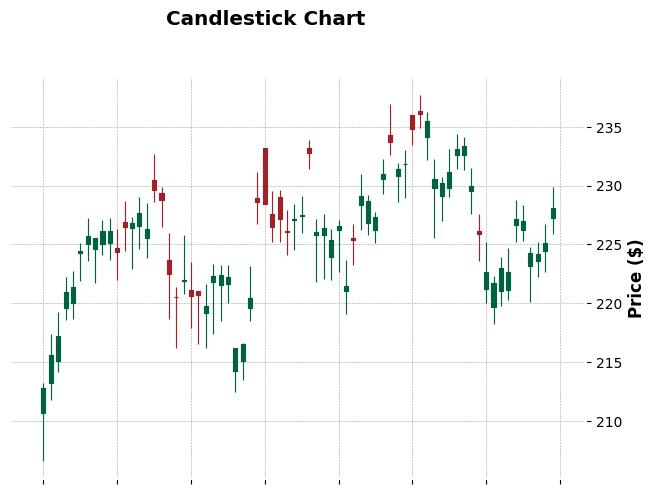

In [25]:
plt.figure(figsize=(6,6))

mpf.plot(
    df,
    type='candle',
    style='charles',
    title="Candlestick Chart",
    ylabel="Price ($)",
    datetime_format='',
    # addplot=mpf.make_addplot(ohlc_data['Close'], color='blue', linestyle='--'),
    volume=False
)

<Figure size 600x600 with 0 Axes>

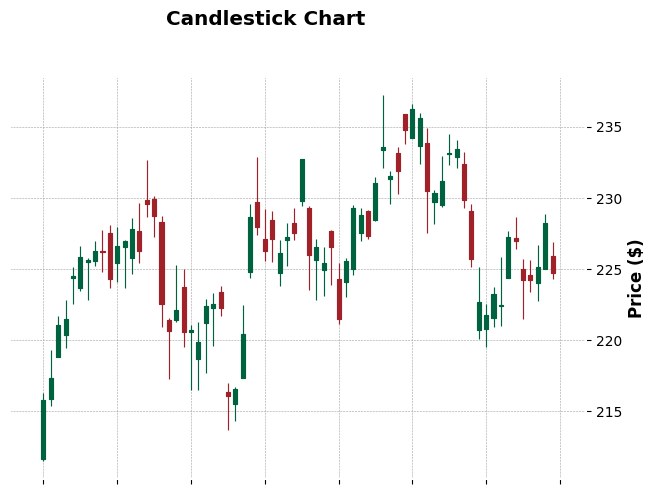

In [28]:
raw_data = load_raw_stock_data("AAPL").to_numpy()
raw_data = raw_data[-n:]
raw_data = raw_data[:, :-1]

df = pd.DataFrame(raw_data, columns=['Open', 'High', 'Low', 'Close'])
df.index = pd.date_range("2023-01-01", periods=len(df), freq="D")

plt.figure(figsize=(6,6))

mpf.plot(
    df,
    type='candle',
    style='charles',
    title="Candlestick Chart",
    ylabel="Price ($)",
    datetime_format='',
    # addplot=mpf.make_addplot(ohlc_data['Close'], color='blue', linestyle='--'),
    volume=False
)